In [1]:
import sys
sys.path.append('../lib')
import numpy as np
import matplotlib.pyplot as plt
from Powerspectra import powerspectrum
from clean_trajectories import iterative_filtering_and_fitting, process_data, clean_trajectory, linear_fit
from MBR_calculation import mean_back_realxation, b_distribution

In [2]:
example_data_path = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2\10_khz\corr\x_trajecories.npy'
example_data = np.load(example_data_path)
f = 1/1000

In [3]:
fk, ps = powerspectrum(example_data, f)
log_fk = np.log(fk)
log_ps = np.log(ps)
log_filtered_fk, log_filtered_ps, filtered_params, total_filtered_indices = iterative_filtering_and_fitting(log_fk, log_ps, N=2, bin_size=20)


In [4]:
from clean_trajectories import bin_data
log_bin_centers, log_bin_ps, bin_edges = bin_data(log_fk, log_ps, 50)


In [5]:
def linear_fit(x, a, b, c):
    return np.log(np.exp(a* x + b)+c)
def initial_guess(log_bin_centers, log_bin_ps):
    c = np.exp(log_bin_ps[-1])
    index_zero = np.argmin(np.abs(log_bin_centers))
    b = log_bin_ps[index_zero] - c
    a = (log_bin_ps[0] - c - b)/log_bin_centers[0]
    return [a, b, c]
    

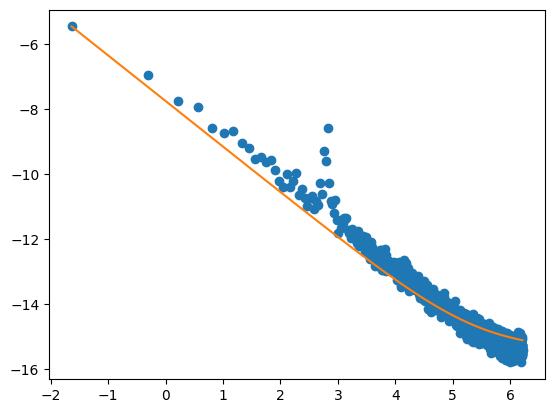

In [6]:
plt.plot(log_bin_centers, log_bin_ps, 'o')
p_0 = initial_guess(log_bin_centers, log_bin_ps)
plt.plot(log_bin_centers, linear_fit(log_bin_centers, *p_0))

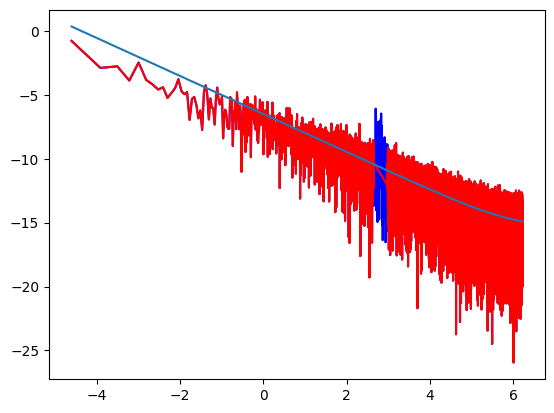

In [7]:
plt.plot(log_fk,log_ps, color='blue')
plt.plot(log_filtered_fk,log_filtered_ps, color='red')
plt.plot(log_fk, linear_fit(log_fk, *filtered_params))

plt.show()


c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\demos\../lib\clean_trajectories.py:47: RuntimeWarning: invalid value encountered in log
  return np.log(np.exp(a* x + b)+c)


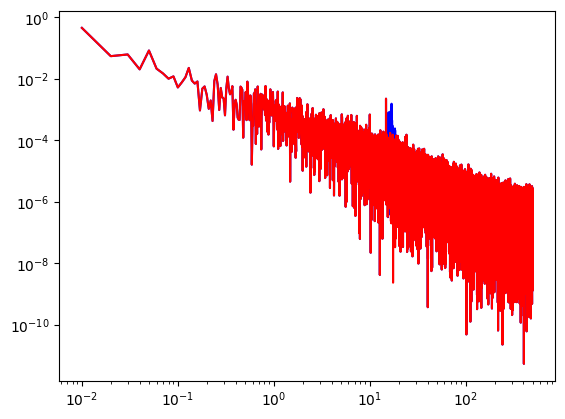

In [8]:
fk, regenerated_ps = process_data(fk, ps, N=1, bin_size=10)
plt.plot(fk,ps, color='blue')
plt.plot(fk,regenerated_ps, color='red')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [9]:
regenerated_trajectory = clean_trajectory(example_data, f, N=1, bin_size=10)

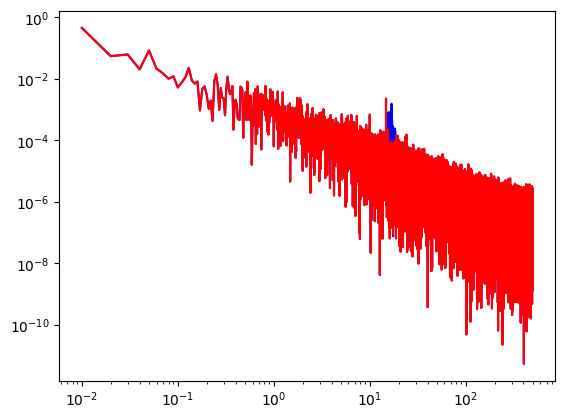

In [13]:
fk_regenerated, ps_regenerated = powerspectrum(regenerated_trajectory, f)

plt.plot(fk, ps, color='blue')
plt.plot(fk_regenerated, ps_regenerated, color='red')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [11]:
dt = 1/f
mbr_original = mean_back_realxation(dt, example_data, dt, dt*1000)
mbr_regenerated = mean_back_realxation(dt, regenerated_trajectory, dt, dt*1000)

Segment size: 1000


Processing segments: 100%|██████████| 98/98 [00:00<00:00, 109.89it/s]


Segment size: 1000


Processing segments: 100%|██████████| 98/98 [00:00<00:00, 108.72it/s]


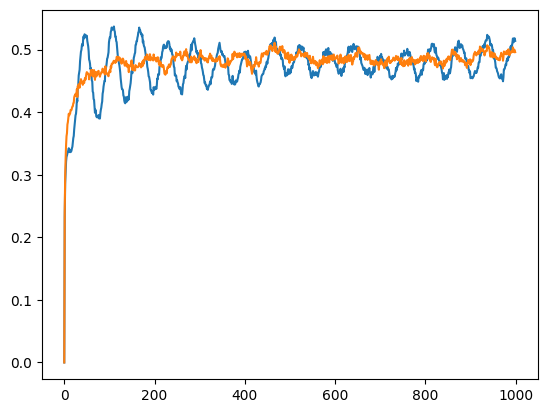

In [12]:
N_plot = 1000
plt.plot(mbr_original[:N_plot])
plt.plot(mbr_regenerated[:N_plot])

In [77]:
def Laplace_NLL(params, x_data, y_data, function):
    y_model = function(x_data, *params)
    NLL = 0
    for y_mode_i, y_data_i in zip(y_model, y_data):
        NLL += y_data_i / y_mode_i + np.log(y_mode_i)
    return NLL


def fit_function(x, a, b, c):
    return a*x**b + c

def initial_guess(x_data, y_data):
    log_x_data = np.log(x_data)
    log_y_data = np.log(y_data)
    c = np.exp(log_y_data[-1])
    index_zero = np.argmin(np.abs(log_x_data))
    a = np.exp(log_y_data[index_zero]) - c
    b = (log_y_data[0] - log_y_data[index_zero] )/log_x_data[0]
    return [a, b, c]

from scipy.optimize import minimize

x_data = fk  # Assuming fk is defined
y_data = ps  # Assuming ps is defined
p_0 = initial_guess(x_data, y_data)




In [289]:
p_0

[6.34784321481754e-05, -1.926870052736066, 8.265134415412302e-07]

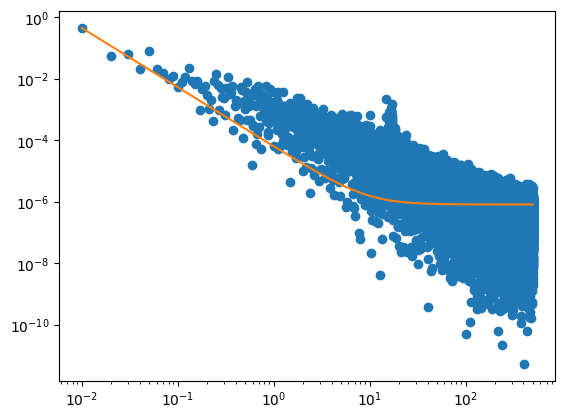

In [288]:
#plot initial guess
plt.plot(x_data, y_data, 'o')
plt.plot(x_data, fit_function(x_data, *p_0))
plt.xscale('log')
plt.yscale('log')
plt.show()


In [131]:
# Correcting the order of arguments in minimize
result = minimize(Laplace_NLL, p_0, args=(x_data, y_data, fit_function), method='Nelder-Mead')

In [132]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -640946.1870976775
             x: [ 2.910e-03 -1.624e+00  2.283e-07]
           nit: 188
          nfev: 328
 final_simplex: (array([[ 2.910e-03, -1.624e+00,  2.283e-07],
                       [ 2.910e-03, -1.624e+00,  2.283e-07],
                       [ 2.910e-03, -1.624e+00,  2.283e-07],
                       [ 2.910e-03, -1.624e+00,  2.283e-07]]), array([-6.409e+05, -6.409e+05, -6.409e+05, -6.409e+05]))

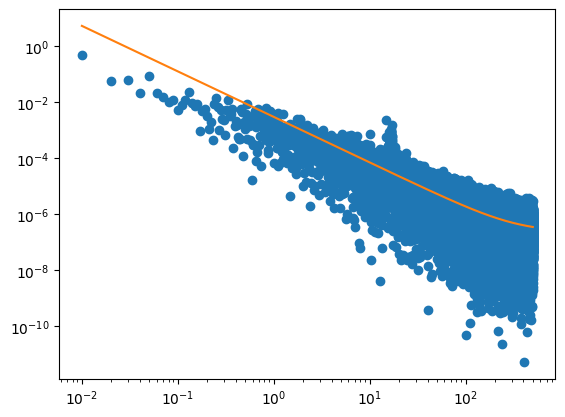

In [206]:
# Plotting the result
plt.plot(x_data, y_data, 'o')

plt.plot(x_data, fit_function(x_data, *result.x))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [263]:
#plot the NLL for every point
suprise = []
for i in range(len(x_data)):
    NLL=Laplace_NLL(result.x, [x_data[i]], [y_data[i]], fit_function)
    expected_NLL = 1+np.log(fit_function(x_data[i], *result.x))
    suprise.append(NLL-expected_NLL)


In [282]:
possible_peak_sizes = np.linspace(1, 5000, 500, dtype=int)

suprise_maxima = []
peak_positions = []
suprise_array_list = []
for peak_size in possible_peak_sizes:
    suprise_array = np.array(suprise)
    suprise_array = np.convolve(suprise_array, np.ones(peak_size), 'VALID')


    suprise_array_list.append(suprise_array)
    suprise_maxima.append(np.max(suprise_array))
    peak_positions.append(np.argmax(suprise_array))

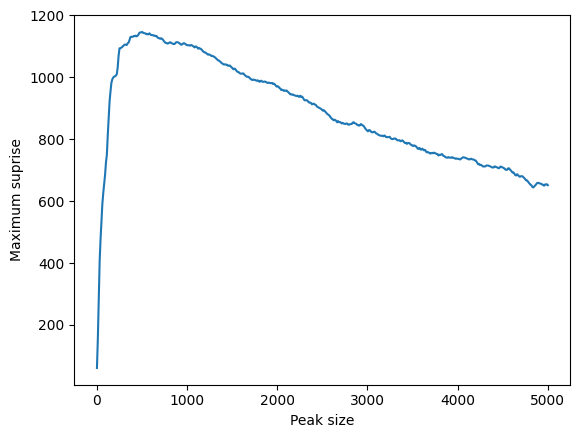

In [283]:
plt.plot(possible_peak_sizes, suprise_maxima)
plt.xlabel('Peak size')
plt.ylabel('Maximum suprise')
plt.show()


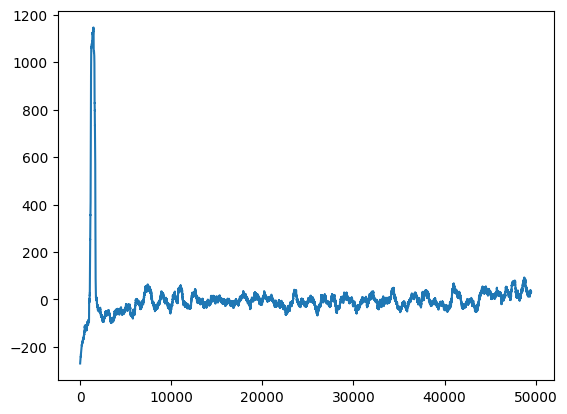

In [284]:
plt.plot(suprise_array_list[np.argmax(suprise_maxima)])

In [285]:
real_peak_size = possible_peak_sizes[np.argmax(suprise_maxima)]
real_peak_position = peak_positions[np.argmax(suprise_maxima)]

In [286]:
exclude_indices = np.array(range(real_peak_position,real_peak_position+ real_peak_size))
filtered_x_data = np.delete(x_data, exclude_indices)
filtered_y_data = np.delete(y_data, exclude_indices)

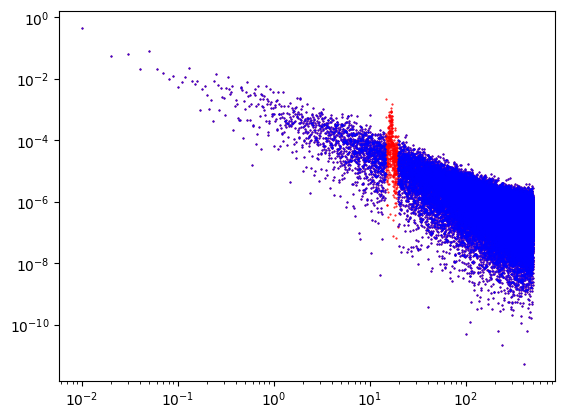

In [287]:
#very small dots
plt.plot(x_data, y_data, 'o', color='red', markersize=0.5)
plt.plot(filtered_x_data, filtered_y_data, 'o', color='blue' , markersize=0.5)
plt.xscale('log')
plt.yscale('log')

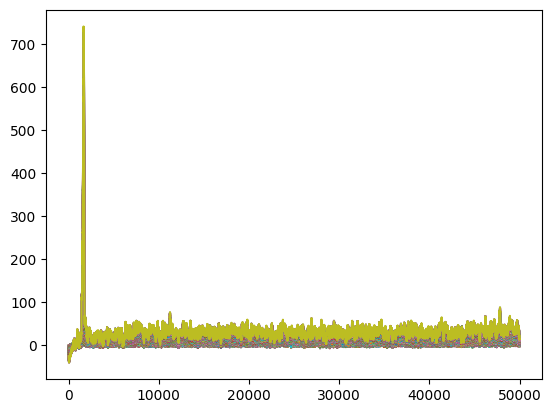

In [185]:
for suprise_array in suprise_array_list:
    plt.plot( suprise_array)

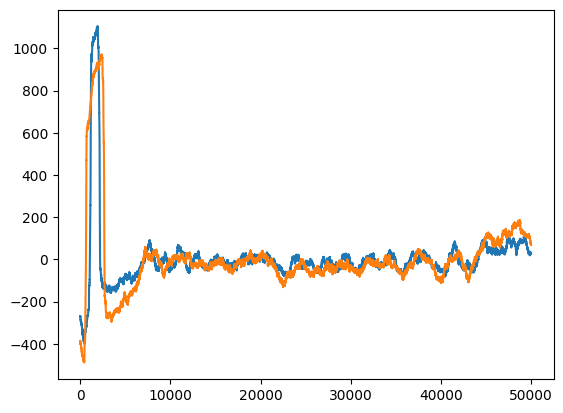

In [222]:
N=1000
plt.plot(np.convolve(suprise, np.ones(N), 'same'))
N=2000
plt.plot(np.convolve(suprise, np.ones(N), 'same'))

In [205]:
np.sum(suprise[1000-100:10000])

559.1034755068675

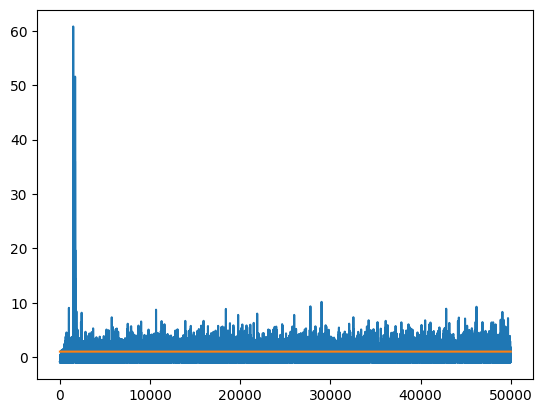

In [191]:
p_significant = 0.05
p_exclusion = p_significant/len(x_data)
NLL_exclusion = -np.log(p_exclusion)
exclude_indices = np.where(NLL > NLL_exclusion)[0]

plt.plot( suprise)
plt.plot(np.ones(len(x_data)))
#plt.xscale('log')
plt.show()

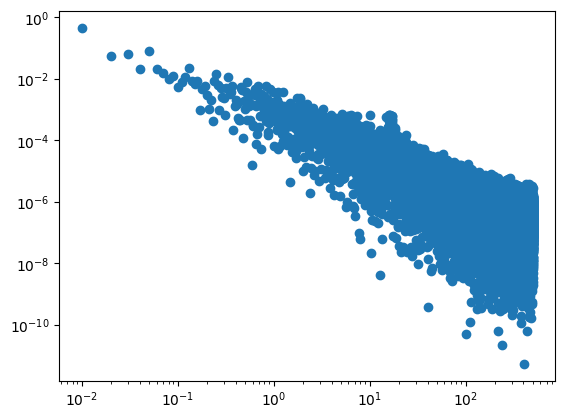

In [115]:
filtered_x_data = np.delete(x_data, exclude_indices)
filtered_y_data = np.delete(y_data, exclude_indices)

plt.plot(filtered_x_data, filtered_y_data, 'o')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [118]:
result = minimize(Laplace_NLL, p_0, args=(filtered_x_data, filtered_y_data, fit_function), method='Nelder-Mead')

C:\Users\jschulz\AppData\Local\Temp\ipykernel_7852\863850048.py:5: RuntimeWarning: invalid value encountered in log
  NLL += y_data_i / y_mode_i + np.log(y_mode_i)


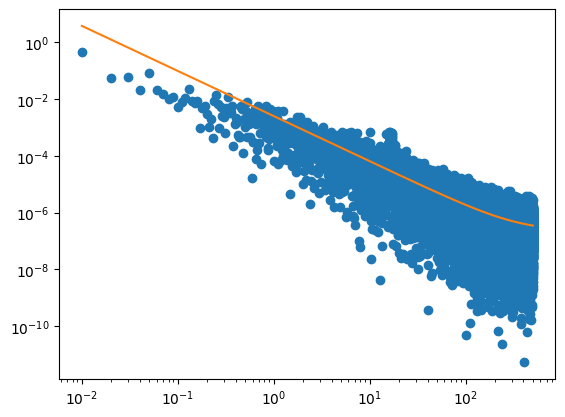

In [119]:
plt.plot(filtered_x_data, filtered_y_data, 'o')
plt.plot(filtered_x_data, fit_function(filtered_x_data, *result.x))
plt.xscale('log')
plt.yscale('log')

plt.show()

In [124]:
NLL = []
for i in range(len(filtered_x_data)):
    NLL.append(Laplace_NLL(result.x, [filtered_x_data[i]], [filtered_y_data[i]], fit_function))


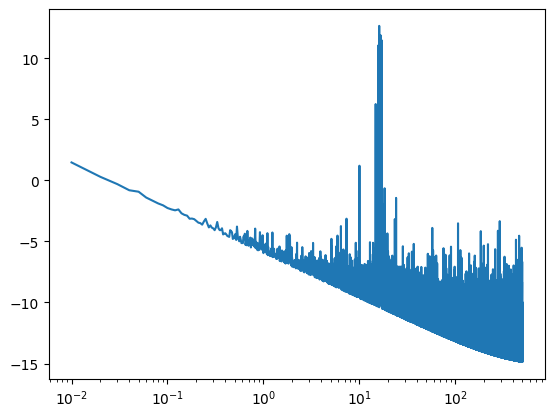

In [127]:
plt.plot(filtered_x_data, NLL)
plt.xscale('log')	